In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
df_LF = pd.read_pickle('gaspereau_lengthfrequency.pickle')
df_FD = pd.read_pickle('gaspereau_fishdetails.pickle')
df_SD = pd.read_pickle('gaspereau_sample.pickle')
df_samplers = pd.read_pickle('gaspereau_samplers.pickle')

# Histograms

In [3]:
def print_hist(dataframe, columns_to_print, colour=0):
    for column in columns_to_print:
        print('--------------------------------------------------\nHistogram:', column.upper())

        plt.figure(figsize=(14, 4))

        n_unique = dataframe[column].nunique()

        max_bins = 100
        if n_unique <= max_bins:
            bins = n_unique
        else:
            bins = max_bins

        # need to sort columns or categorical values are all over the place (still not perfect, but way better)
        dataframe.sort_values(column)[column].hist(bins=bins, color=sns.color_palette()[colour], xrot=90)

        plt.show()

--------------------------------------------------
Histogram: COUNT


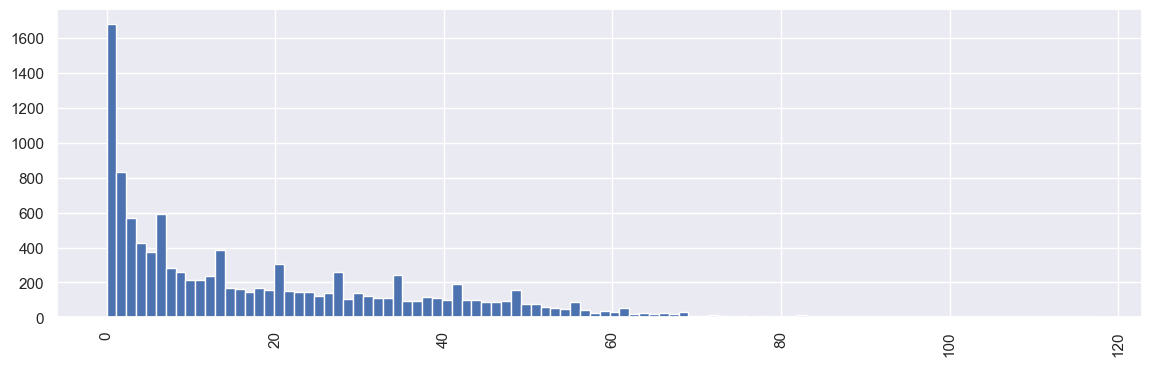

--------------------------------------------------
Histogram: LENGTH_BIN_ID


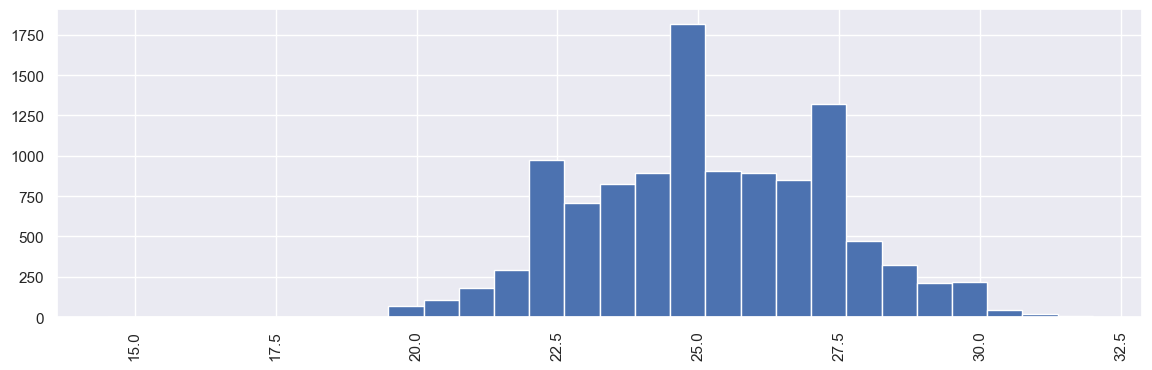

In [4]:
print_hist(df_LF, list(df_LF.columns)[:2])

In [5]:
# all fd columns
df_FD.columns

Index(['sample_id', 'DATETIME', 'SITE', 'CONDITION', 'fish_number', 'FL_WET',
       'FL_FROZEN', 'fish_length', 'fish_weight', 'SPECIES', 'SEX',
       'maturity_id', 'gonad_weight', 'AGING_PERSON_1', 'AGE_1', 'FSP_1',
       'AGE_COMMENTS_1', 'AGING_PERSON_2', 'AGE_2', 'FSP_2', 'AGE_COMMENTS_2',
       'ENVELOP_COMMENTS', 'AGE_NOTES', 'FSP_NOTES'],
      dtype='object')

--------------------------------------------------
Histogram: SITE


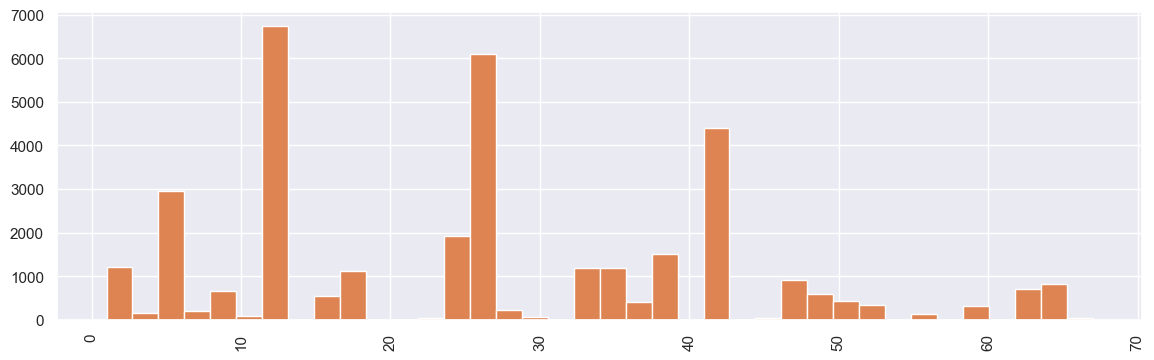

--------------------------------------------------
Histogram: CONDITION


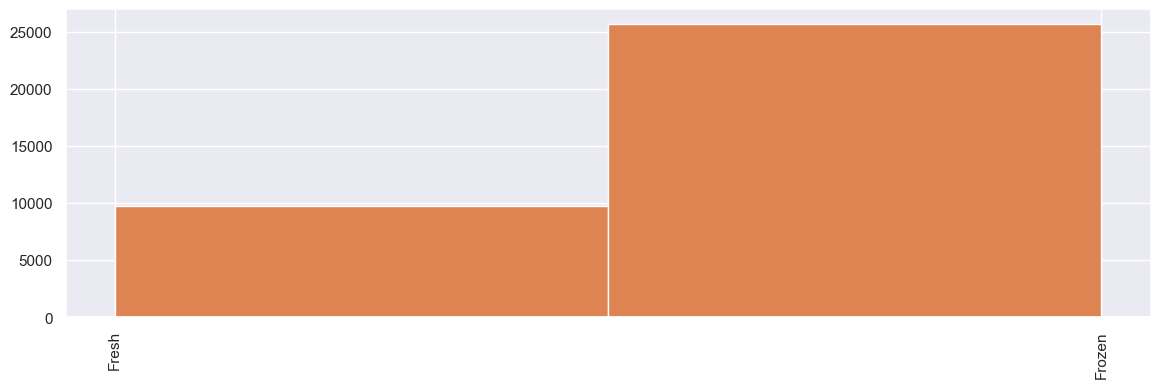

--------------------------------------------------
Histogram: FISH_NUMBER


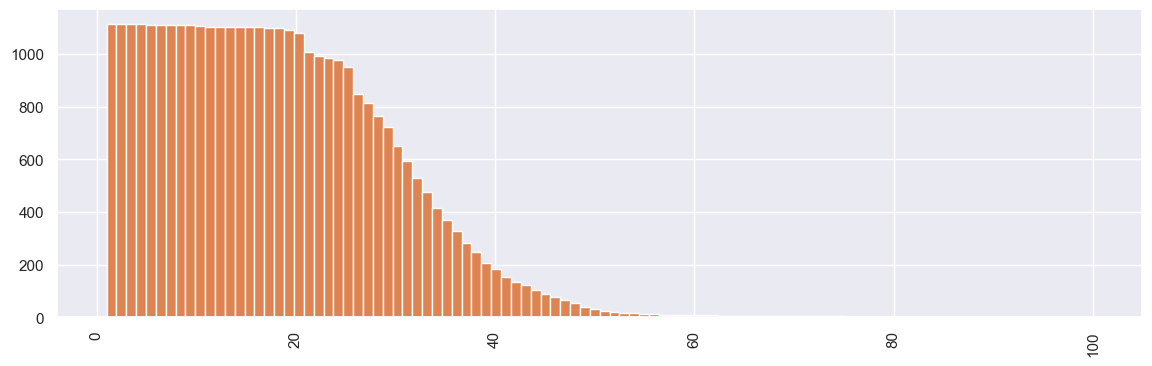

--------------------------------------------------
Histogram: FL_WET


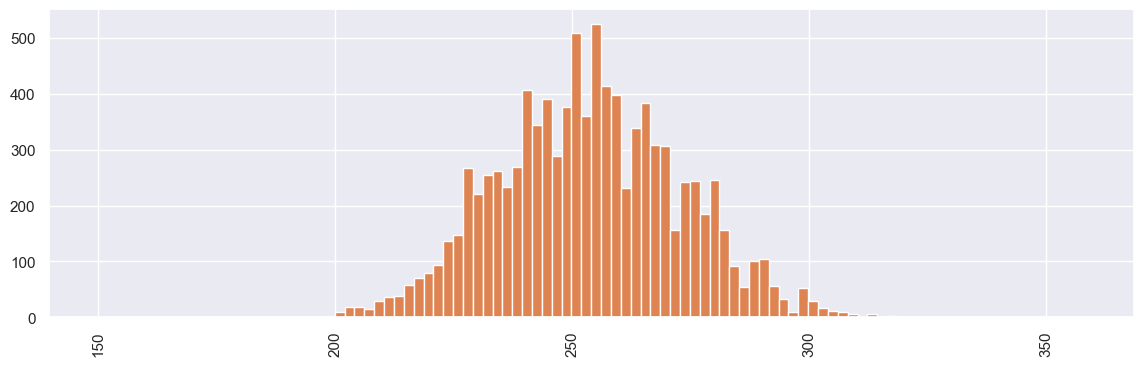

--------------------------------------------------
Histogram: FL_FROZEN


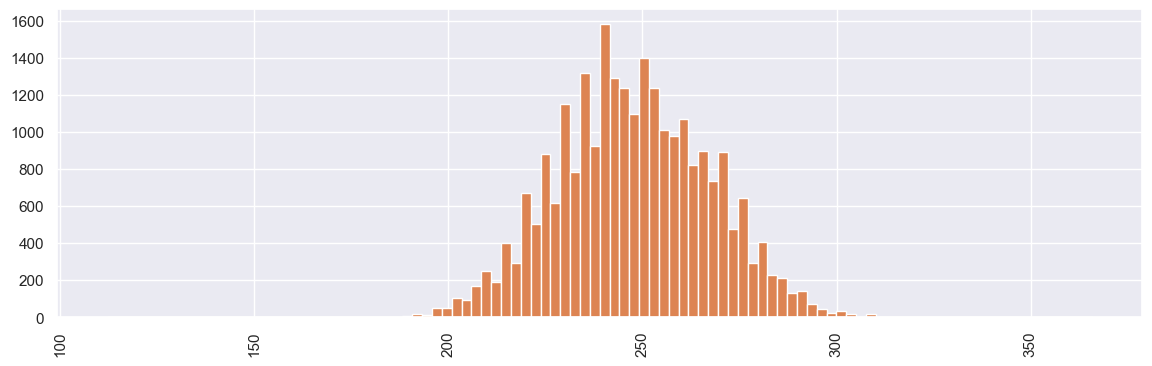

--------------------------------------------------
Histogram: FISH_LENGTH


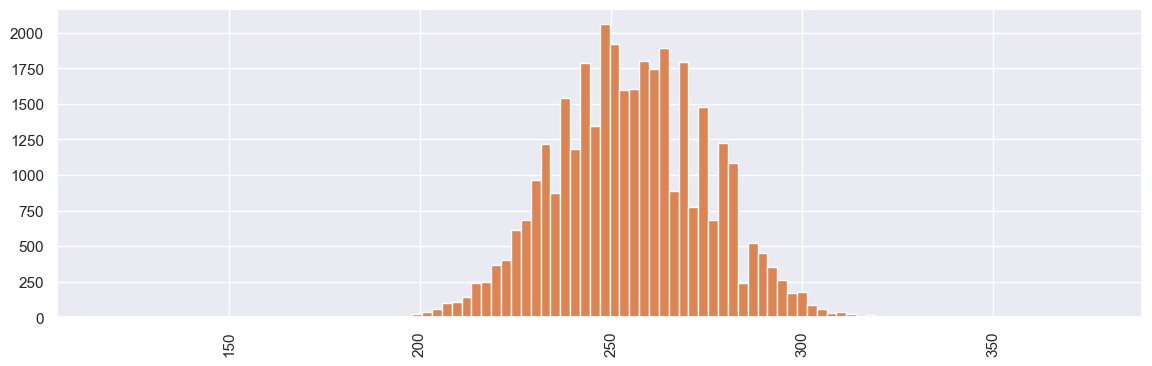

--------------------------------------------------
Histogram: FISH_WEIGHT


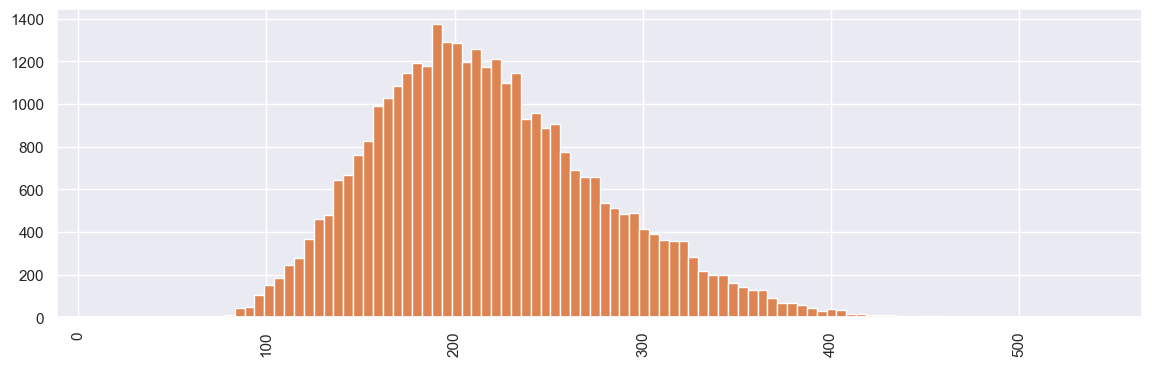

--------------------------------------------------
Histogram: SPECIES


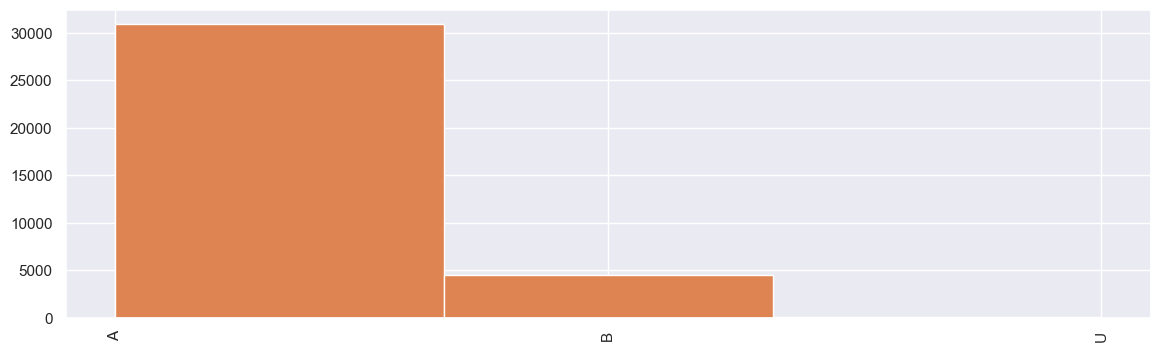

--------------------------------------------------
Histogram: SEX


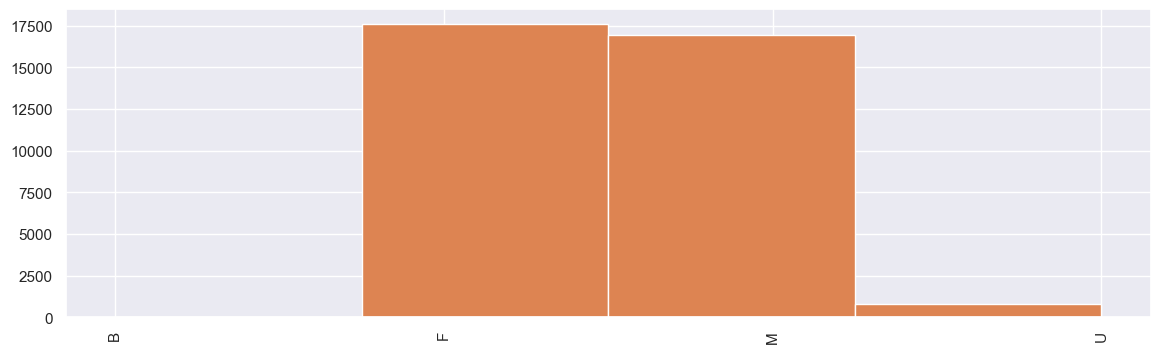

--------------------------------------------------
Histogram: MATURITY_ID


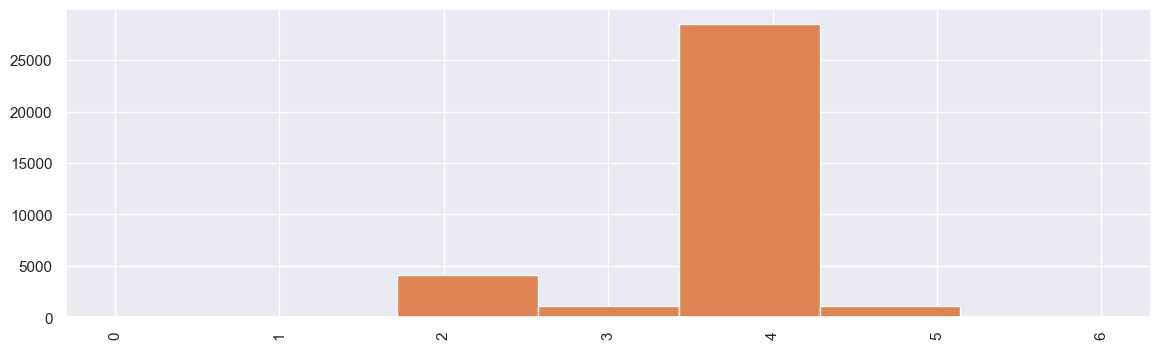

--------------------------------------------------
Histogram: GONAD_WEIGHT


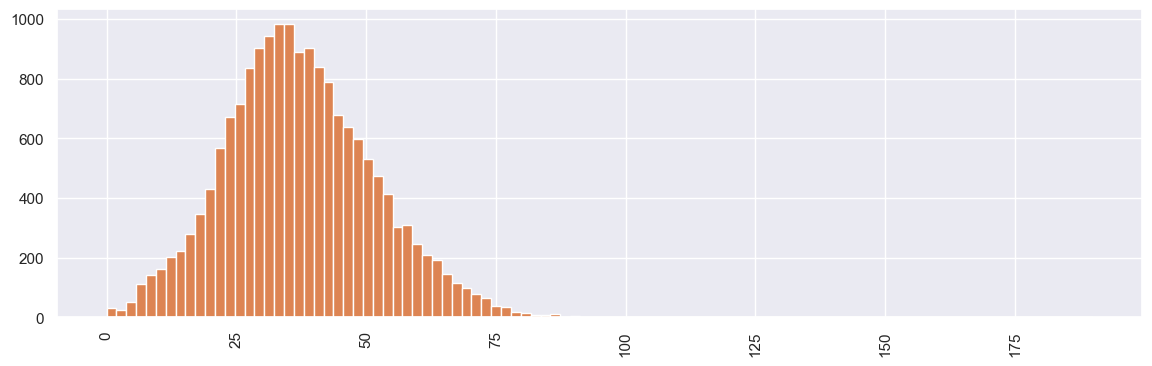

--------------------------------------------------
Histogram: AGING_PERSON_1


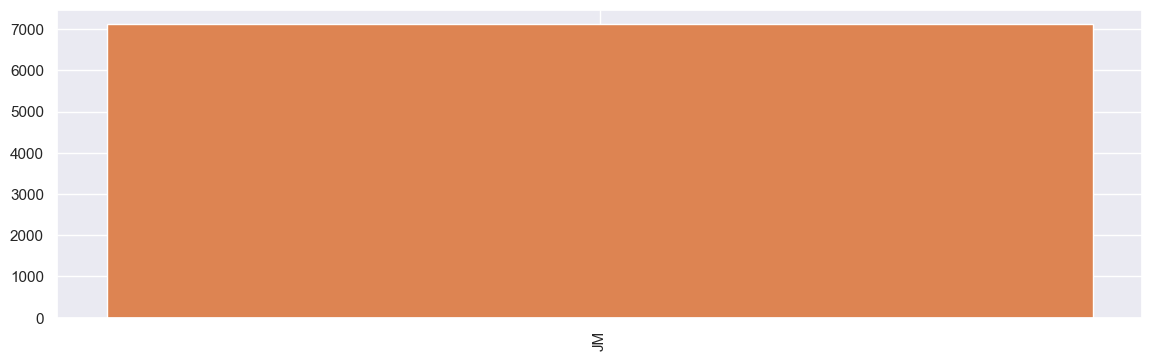

--------------------------------------------------
Histogram: AGE_1


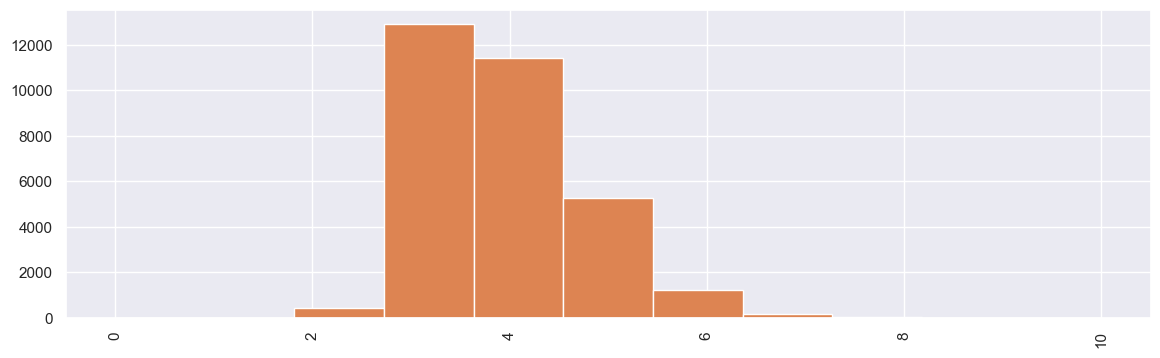

--------------------------------------------------
Histogram: FSP_1


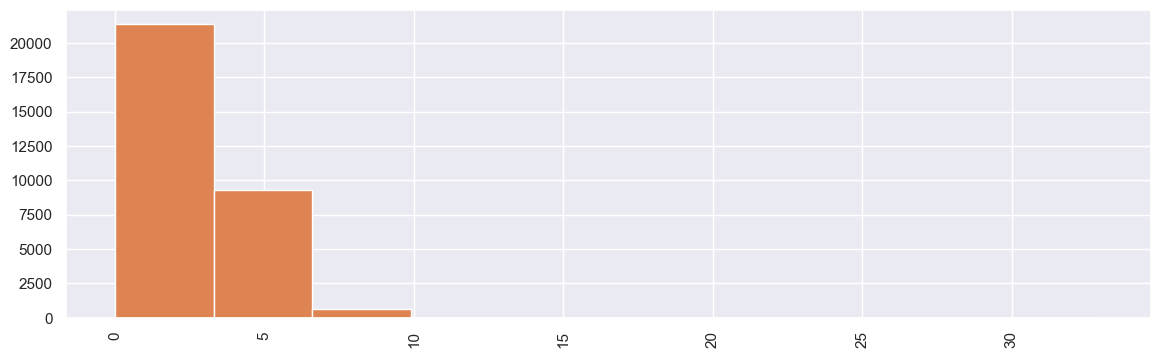

--------------------------------------------------
Histogram: AGING_PERSON_2


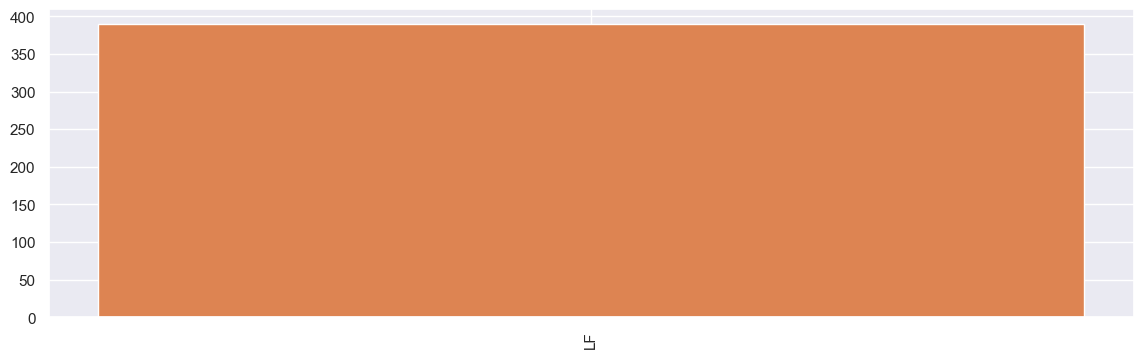

--------------------------------------------------
Histogram: AGE_2


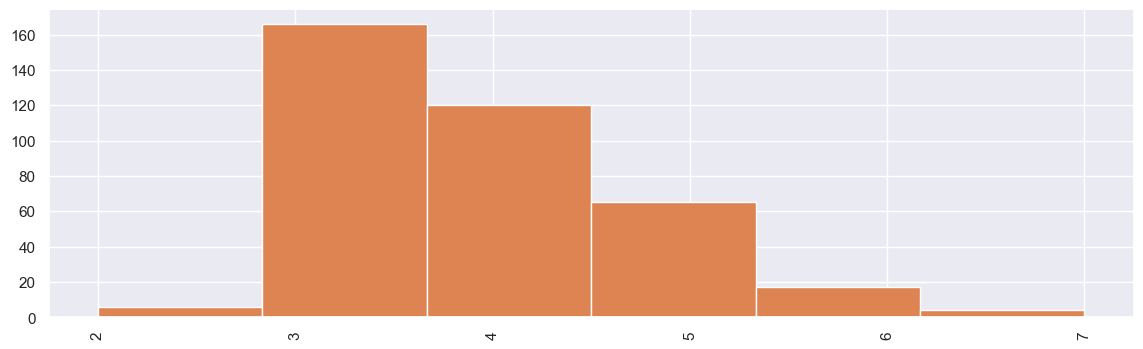

--------------------------------------------------
Histogram: FSP_2


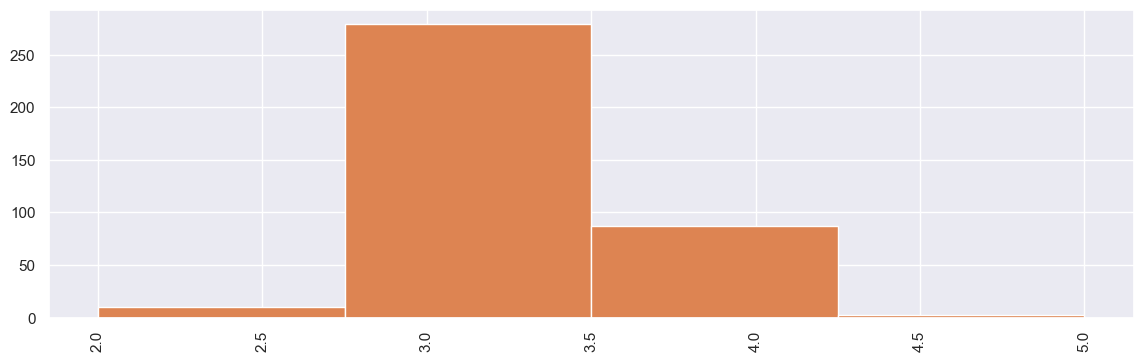

--------------------------------------------------
Histogram: AGE_COMMENTS_2


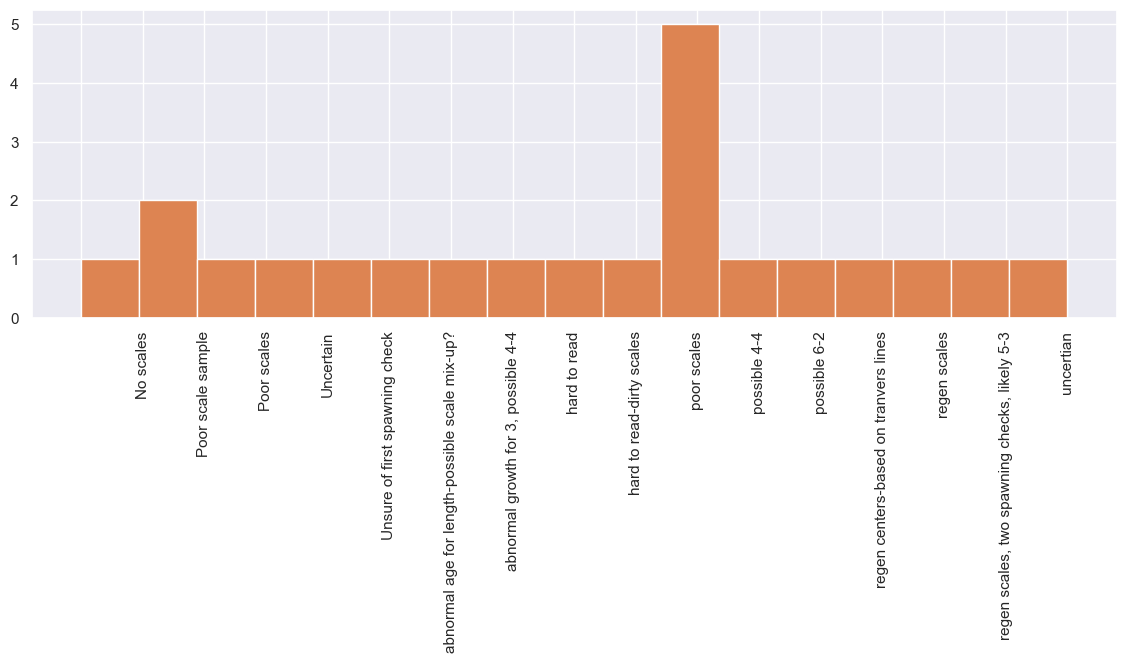

--------------------------------------------------
Histogram: ENVELOP_COMMENTS


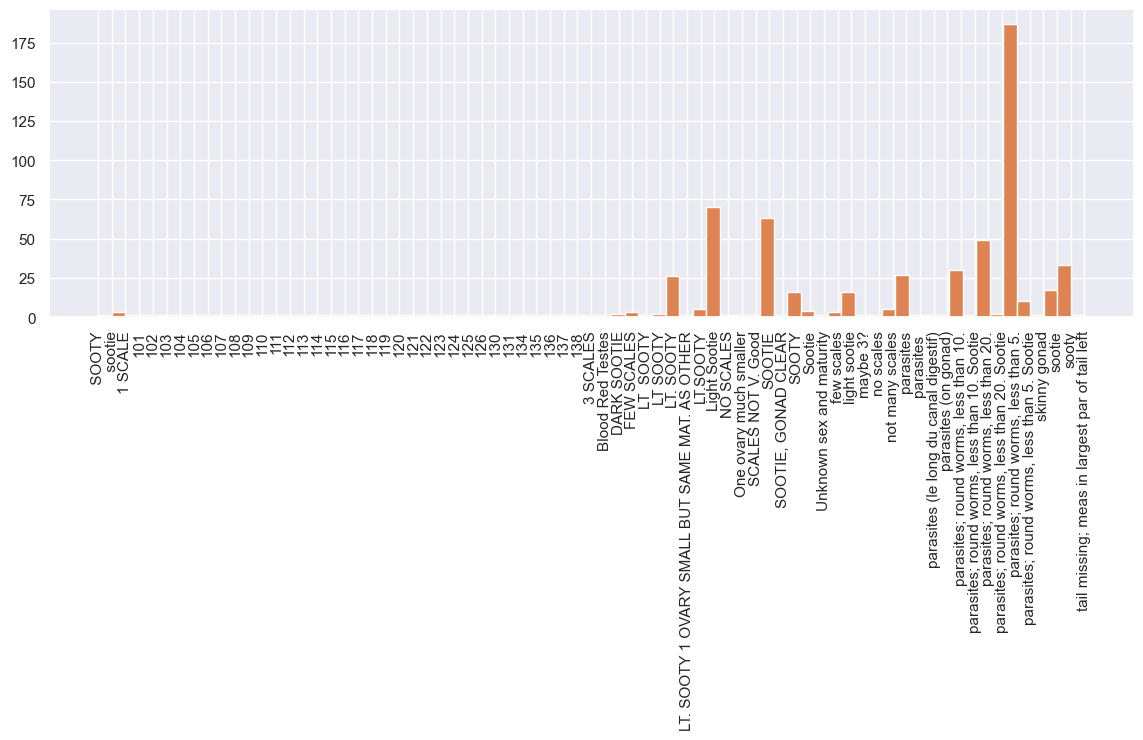

--------------------------------------------------
Histogram: AGE_NOTES


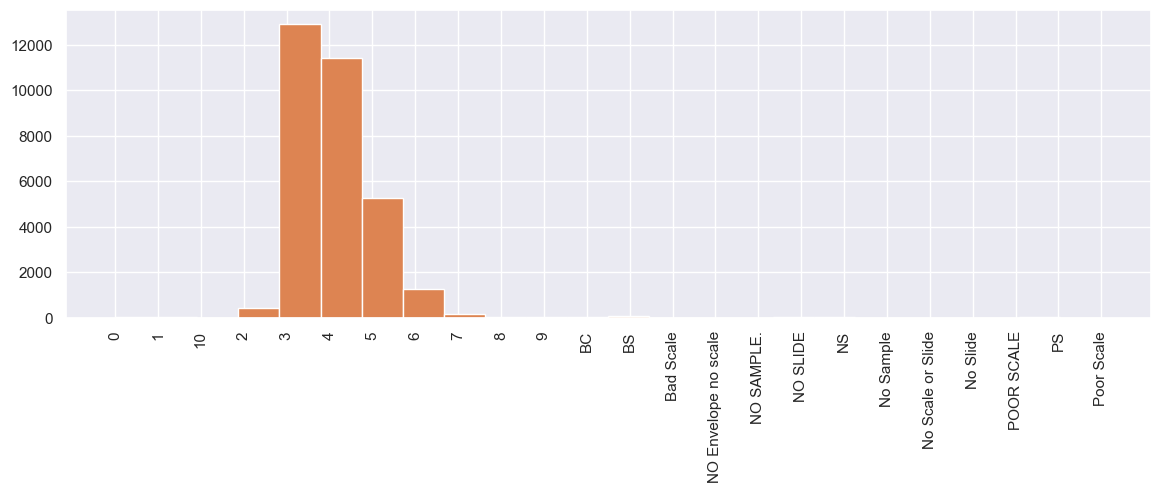

--------------------------------------------------
Histogram: FSP_NOTES


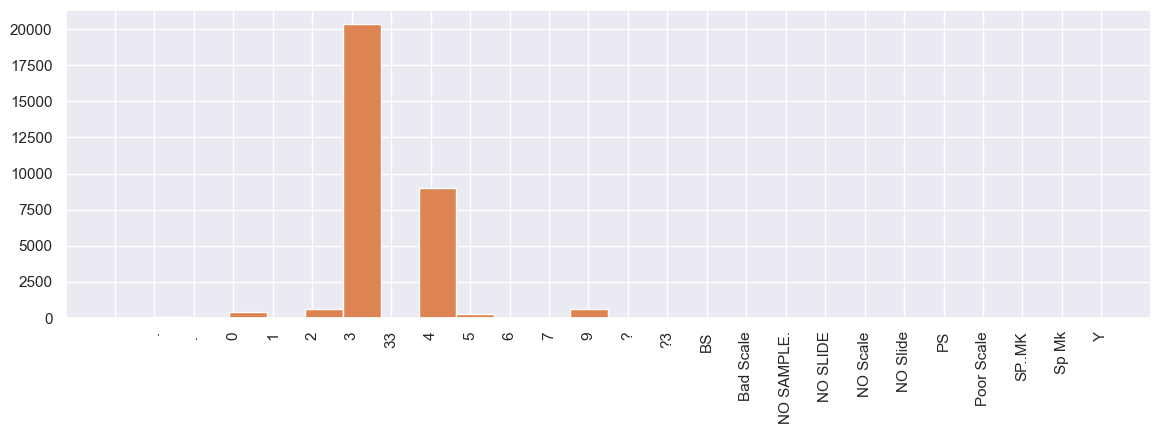

In [6]:
fd_column_list = [
    'SITE', 'CONDITION', 'fish_number', 'FL_WET',
    'FL_FROZEN', 'fish_length', 'fish_weight', 'SPECIES', 'SEX',
    'maturity_id', 'gonad_weight', 'AGING_PERSON_1', 'AGE_1', 'FSP_1',
    'AGING_PERSON_2', 'AGE_2', 'FSP_2', 'AGE_COMMENTS_2',
    'ENVELOP_COMMENTS', 'AGE_NOTES', 'FSP_NOTES'
]
print_hist(df_FD, fd_column_list, 1)

In [7]:
# all sd columns
df_SD.columns

Index(['id', 'sample_date', 'district_id', 'fishing_area_id', 'SAMPLER',
       'CODE', 'gear_id', 'SITE', 'NO_NETS', 'catch_weight_lbs',
       'HOURS_FISHED', 'ZONE', 'LAST_NAME', 'COMMENTS', 'BYCATCH_SBASS',
       'BYCATCH_SHAD', 'BYCATCH_OTHER', 'remarks', 'sample_weight_lbs'],
      dtype='object')

--------------------------------------------------
Histogram: DISTRICT_ID


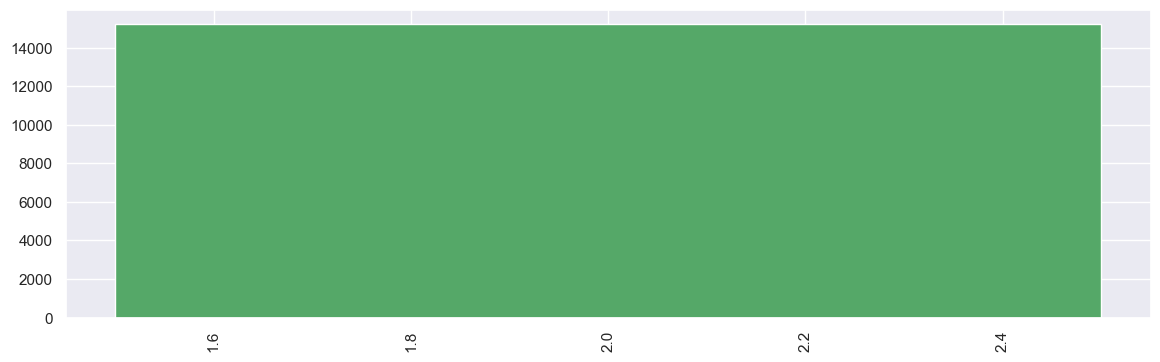

--------------------------------------------------
Histogram: FISHING_AREA_ID


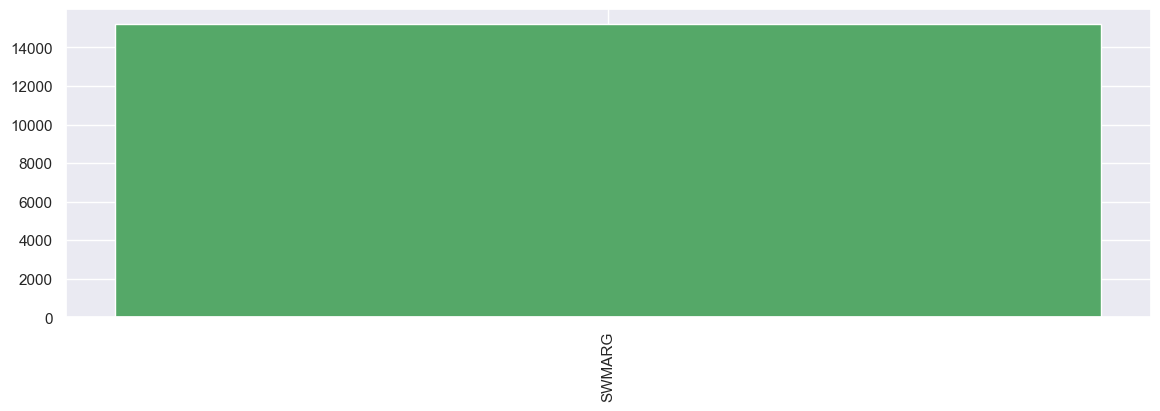

--------------------------------------------------
Histogram: SAMPLER


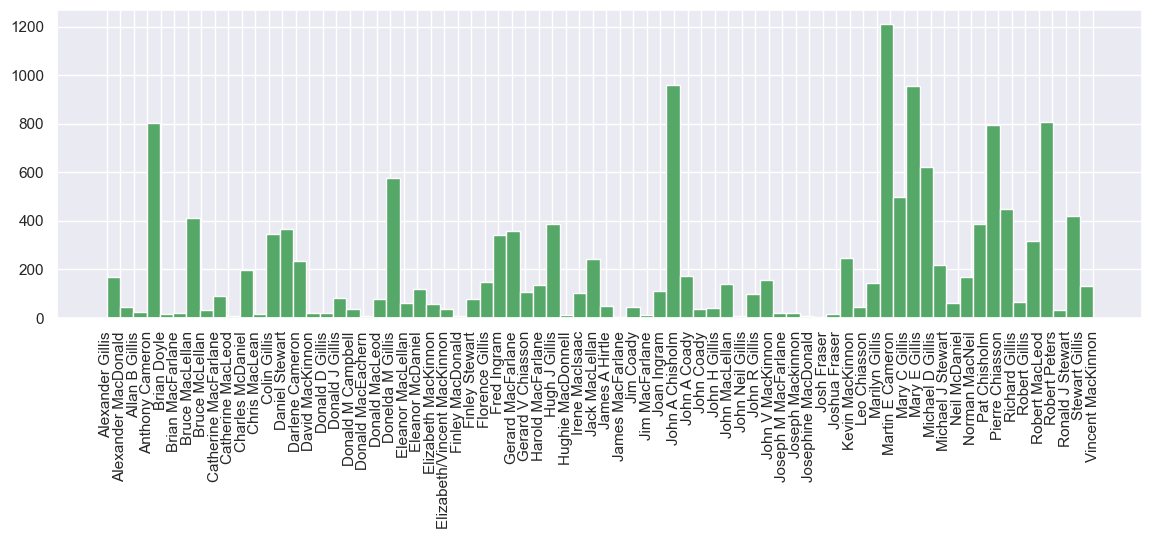

--------------------------------------------------
Histogram: GEAR_ID


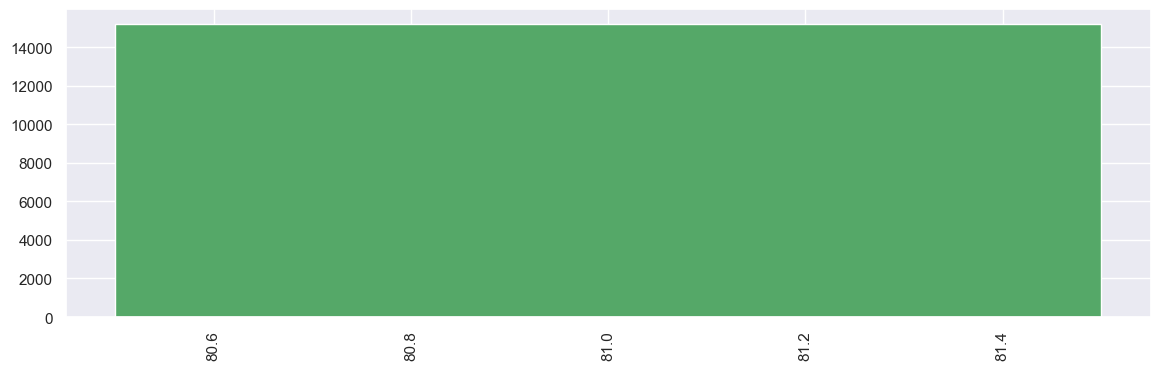

--------------------------------------------------
Histogram: SITE


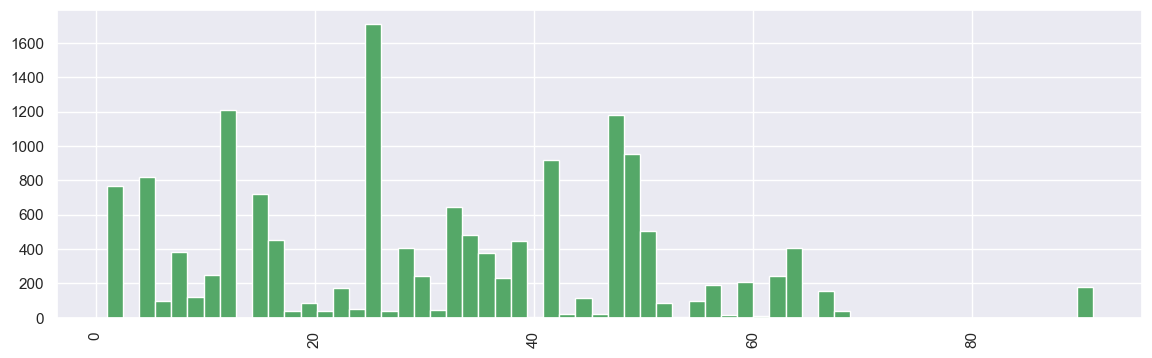

--------------------------------------------------
Histogram: NO_NETS


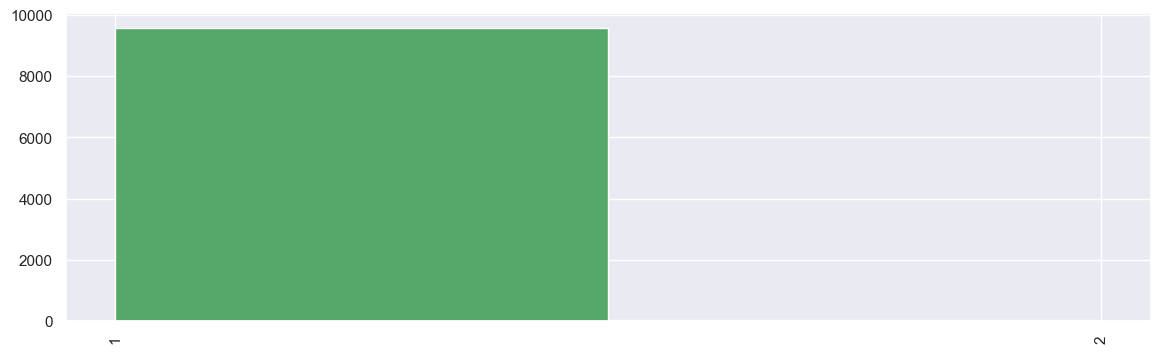

--------------------------------------------------
Histogram: CATCH_WEIGHT_LBS


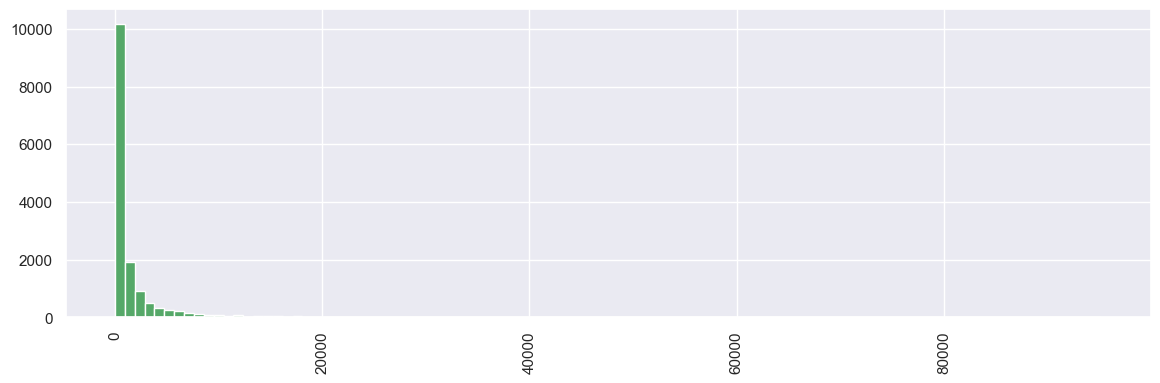

--------------------------------------------------
Histogram: HOURS_FISHED


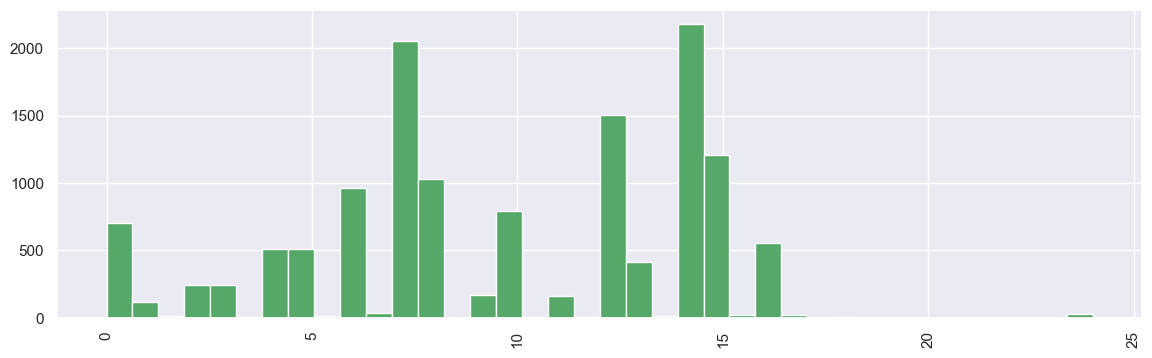

--------------------------------------------------
Histogram: ZONE


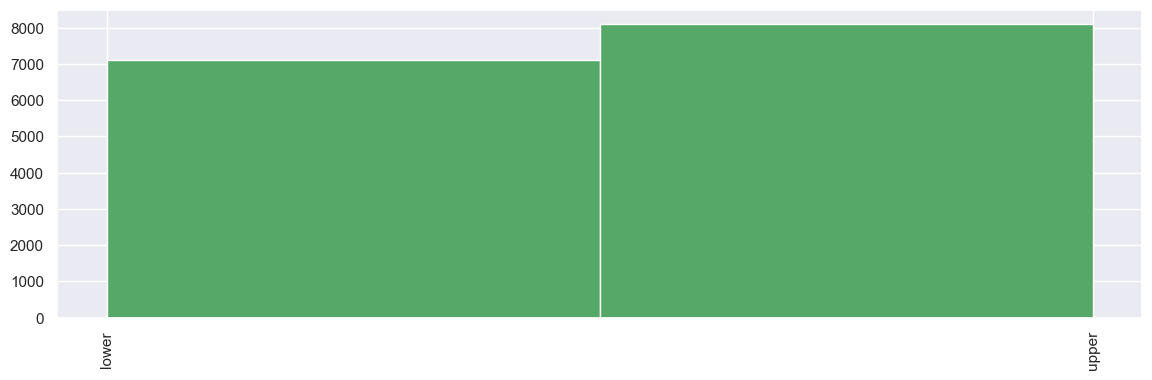

--------------------------------------------------
Histogram: LAST_NAME


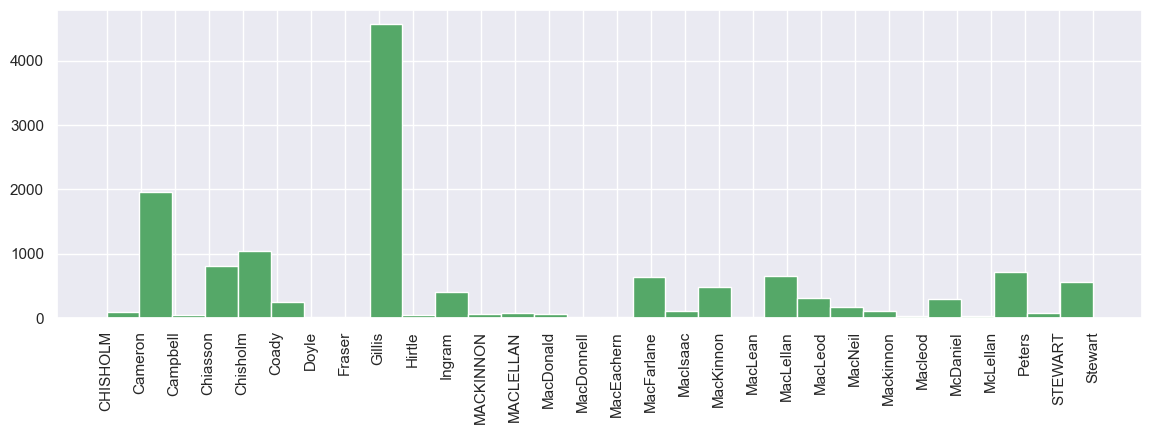

--------------------------------------------------
Histogram: COMMENTS


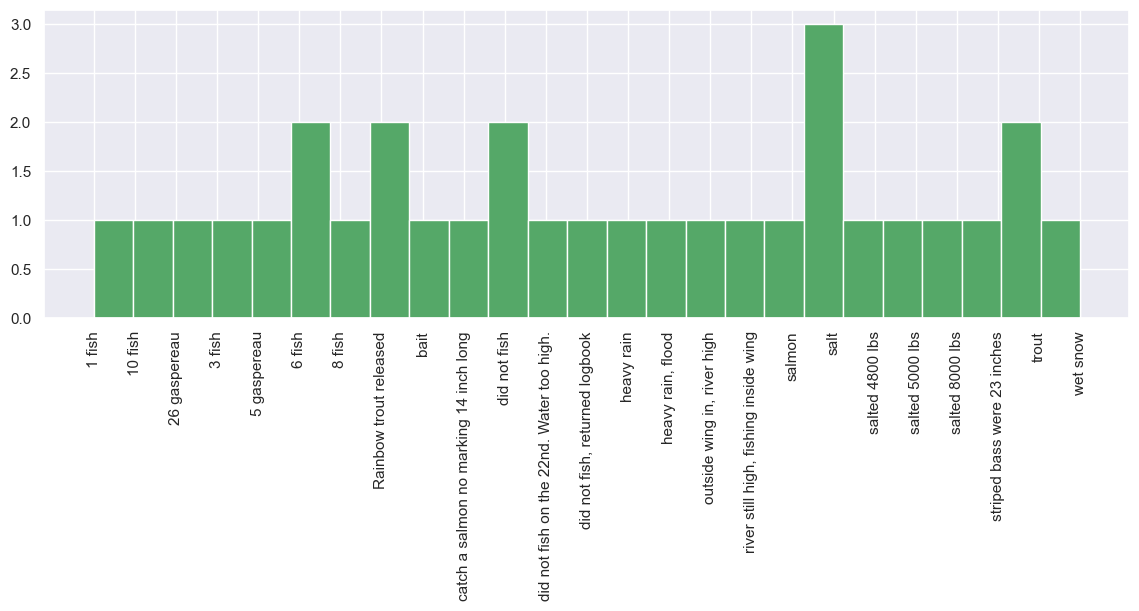

--------------------------------------------------
Histogram: BYCATCH_SBASS


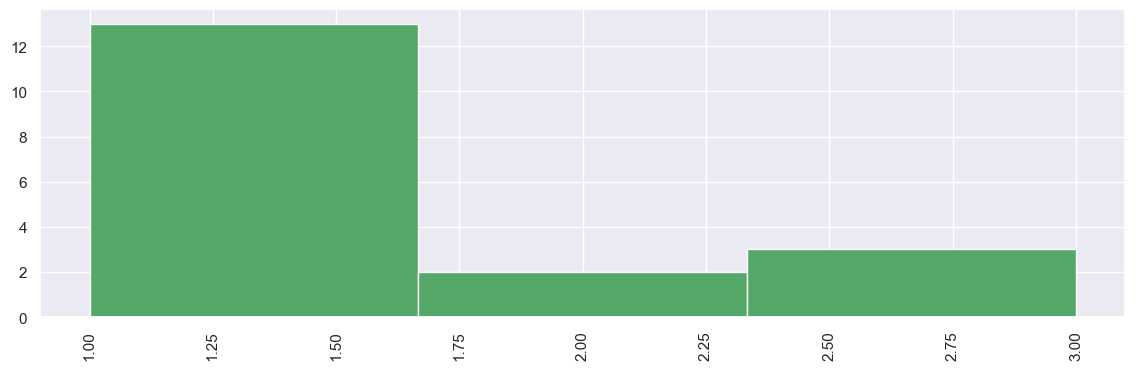

--------------------------------------------------
Histogram: BYCATCH_SHAD


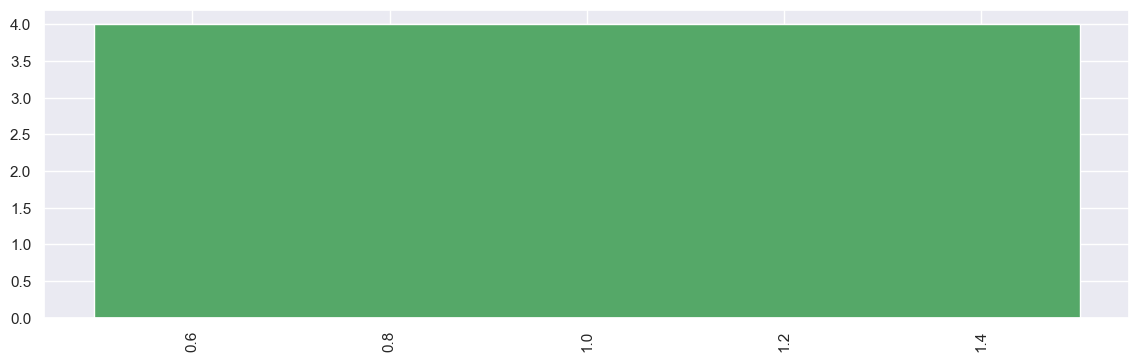

--------------------------------------------------
Histogram: BYCATCH_OTHER


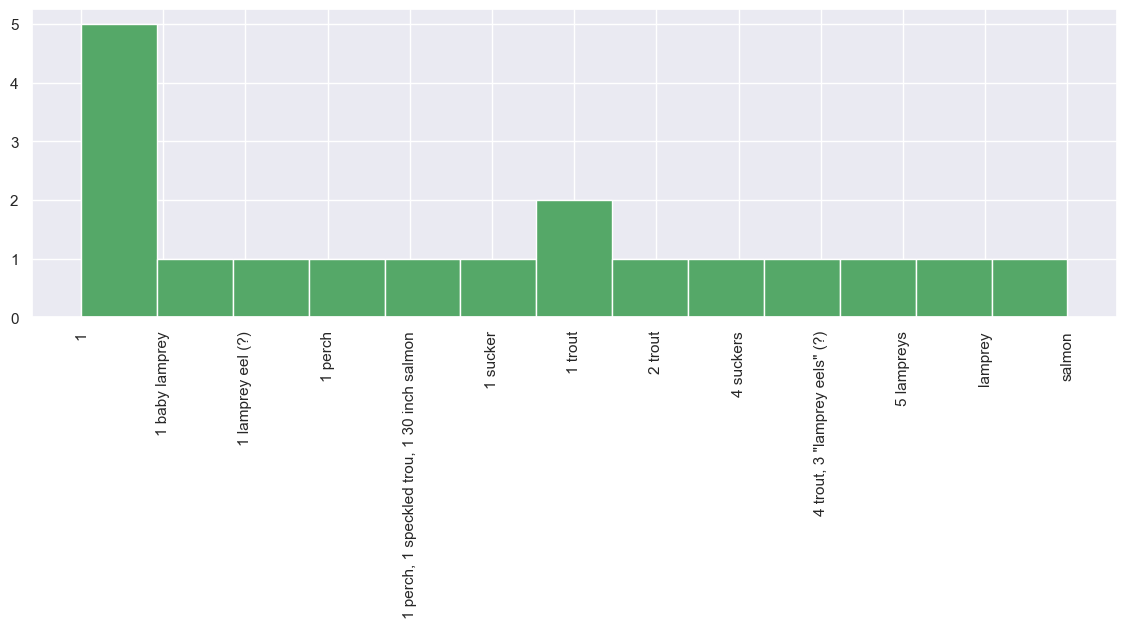

--------------------------------------------------
Histogram: REMARKS


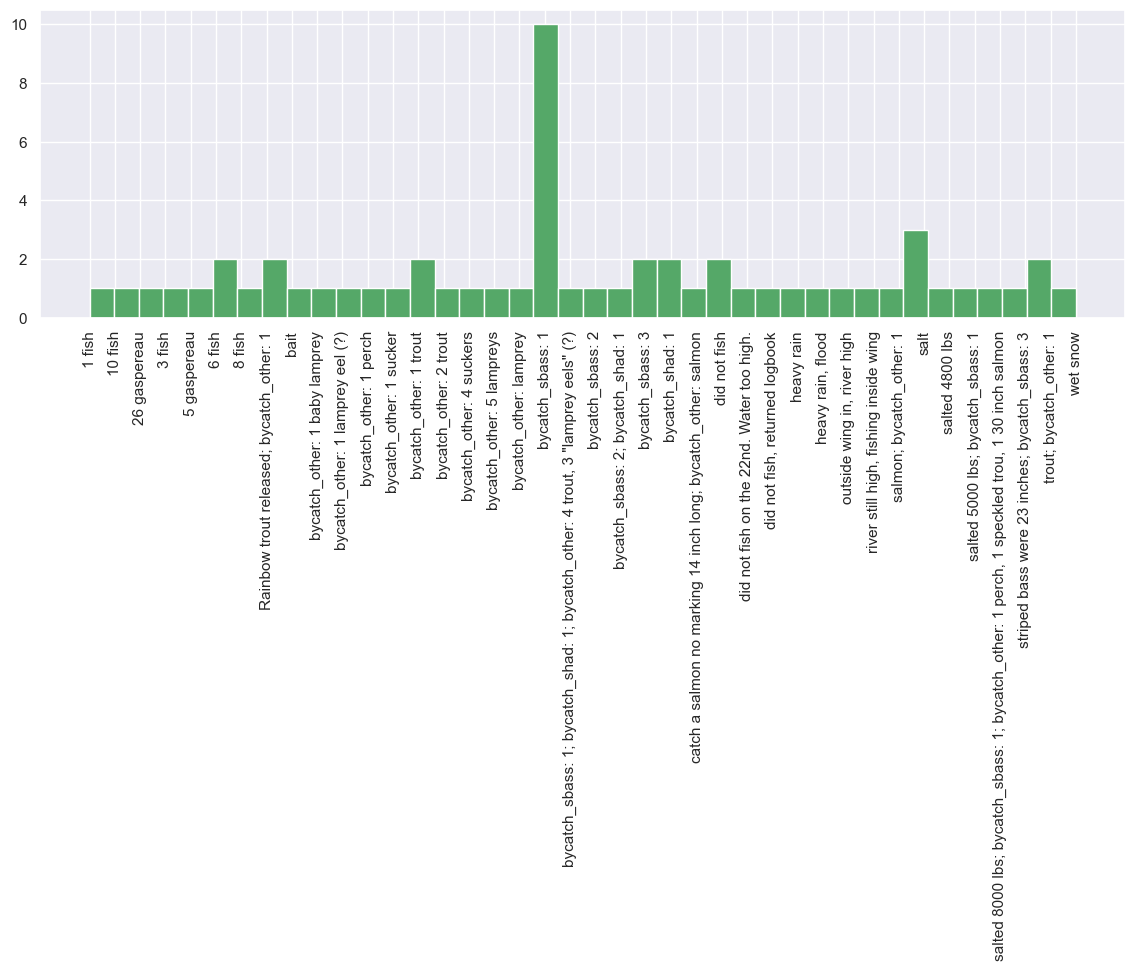

--------------------------------------------------
Histogram: SAMPLE_WEIGHT_LBS


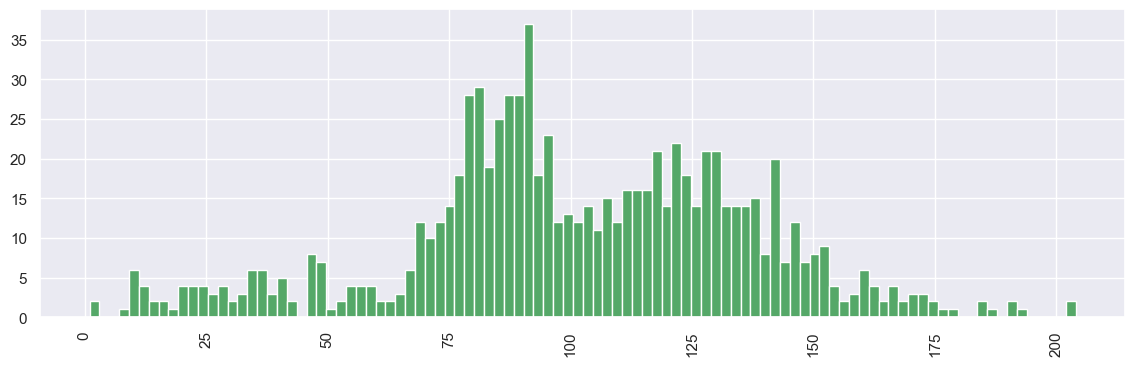

In [9]:
sd_column_list = [
    'district_id', 'fishing_area_id', 'SAMPLER',
    'gear_id', 'SITE', 'NO_NETS', 'catch_weight_lbs',
    'HOURS_FISHED', 'ZONE', 'LAST_NAME', 'COMMENTS', 'BYCATCH_SBASS',
    'BYCATCH_SHAD', 'BYCATCH_OTHER', 'remarks', 'sample_weight_lbs'
]
print_hist(df_SD, sd_column_list, 2)

# Time Series

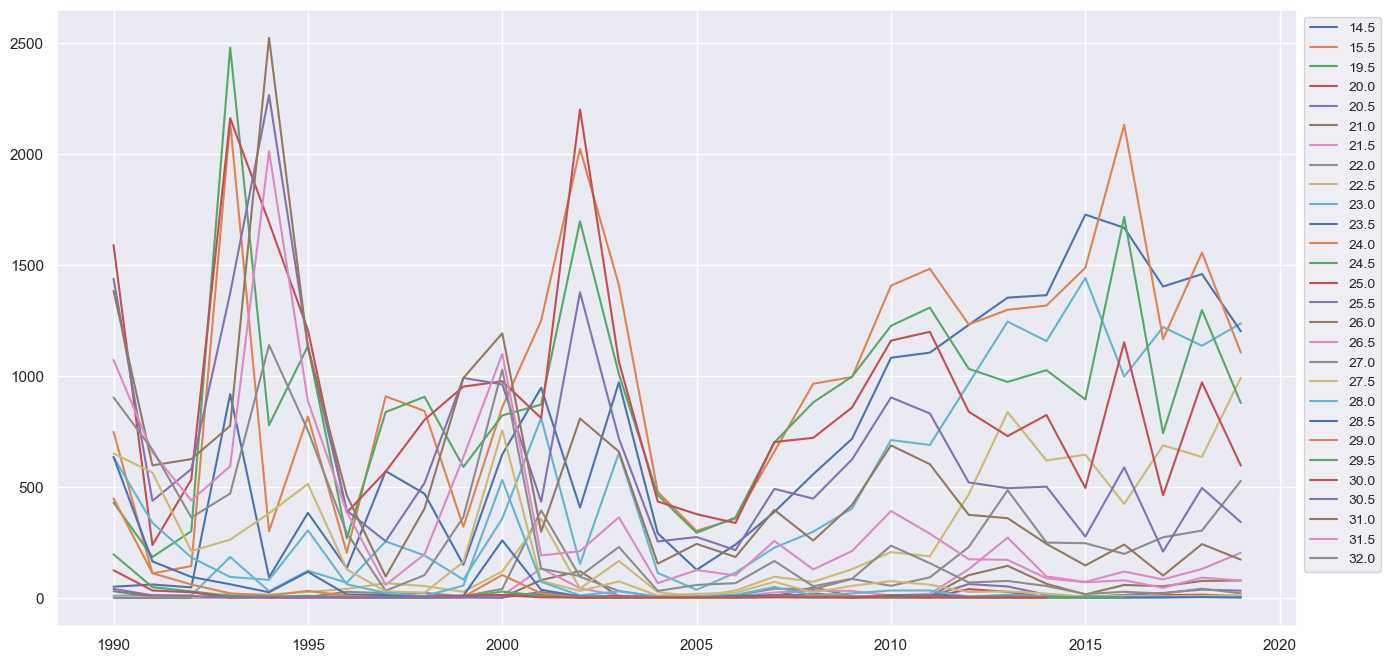

In [130]:
# Length Frequency Time Series

# group the lf dataframe

TEMP = df_LF.copy()
TEMP['YEAR'] = df_LF.sample_id//1000000
TEMP = TEMP.drop('sample_id', axis=1)
TEMP = TEMP[TEMP.YEAR < 2023]

TEMP = TEMP.groupby(['YEAR', 'length_bin_id']).sum().reset_index(level=1)

# plot the grouped series
plt.figure(figsize=(16, 8))

for i in sorted([str(x) for x in TEMP.length_bin_id.unique()]):

    i = float(i)

    try:
        plot = sns.lineplot(
            x = TEMP[TEMP.length_bin_id == i].index, 
            y = TEMP[TEMP.length_bin_id == i]['count'],
            errorbar = ('pi', 50), 
#             color = sns.color_palette()[colour],  # MAYBE A GRADIENT COLOUR SCHEME WOULD BE READABLE, OTHERWISE, MAYBE HEATMAP?
            label=i
        )
    except TypeError:  # not sure what errors mean, probably not enough data for plot, skip either way
        pass
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plot.set_xlim(1982, 2022)

plt.show()

In [36]:
def print_timeseries(dataframe, columns, colour=0):
    
    for column in columns:

        print('\n-------------------------------------------------------\n', column.upper(), sep='')
        plt.figure(figsize=(14, 4))

        plot = sns.lineplot(
            x = dataframe.DATETIME.dt.year, 
            y = dataframe[column].astype(float),  # cast int to float or get ValueErrors with IQR (pi 50)
            errorbar = ('pi', 50), 
            color = sns.color_palette()[colour]
        )

        # show entire dataset time period for all plots
        plot.set_xlim(1982, 2022)

        plt.show()